### Make sure some stuff are set up

1. Run `jupyter nbextension enable --py widgetsnbextension` to enable widgets

2. Install graphviz through ``brew`` or ``apt-get``

3. Install graphviz's Python binding:

    import sys
    !{sys.executable} -m pip install graphviz

### Import dependencies

In [93]:
import matplotlib
import pandas as pd
import numpy as np

from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeRegressor, DecisionTreeClassifier, export_graphviz

from graphviz import Source

from IPython.display import SVG
from IPython.display import display                               
from ipywidgets import interactive

import ipywidgets as widgets

### How does the data look like?

NOTE: Trying to figure out which of the CSV files to use from the Kaggle dataset right now

According to the ProPublica description of their [data](https://www.propublica.org/article/how-we-analyzed-the-compas-recidivism-algorithm) they considered the following factors:
race, criminal history, future recidivism, charge degree, gender, and age.

They first did a logistic regression to test for racial disparities in results. They then ran a Cox proportional hazards model (which is what COMPAS's parent company did to assess the algorithm) to test the predictive accuracy of the COMPAS algorithm.  

Variables in the logistic regression included:
- each race category
- each age category
- number of priors
- misdimeanor
- two year recidivism 
- each age category (e.g. less than 25, greater than 45, etc)
- each sex category

In [30]:
# basic COMPAS scores CSV, with sex, race and just a few other useful predictors. not much to go on
compas_scores_raw_filename = 'data/compas-scores-raw.csv'
df_compas_raw = pd.read_csv(compas_scores_raw_filename)
df_compas_raw.head()

,Person_ID,AssessmentID,Case_ID,Agency_Text,LastName,FirstName,MiddleName,Sex_Code_Text,Ethnic_Code_Text,DateOfBirth,...,RecSupervisionLevel,RecSupervisionLevelText,Scale_ID,DisplayText,RawScore,DecileScore,ScoreText,AssessmentType,IsCompleted,IsDeleted
0,50844,57167,51950,PRETRIAL,Fisher,Kevin,NaN,Male,Caucasian,12/05/92,...,1,Low,7,Risk of Violence,-2.08,4,Low,New,1,0
1,50844,57167,51950,PRETRIAL,Fisher,Kevin,NaN,Male,Caucasian,12/05/92,...,1,Low,8,Risk of Recidivism,-1.06,2,Low,New,1,0
2,50844,57167,51950,PRETRIAL,Fisher,Kevin,NaN,Male,Caucasian,12/05/92,...,1,Low,18,Risk of Failure to Appear,15.00,1,Low,New,1,0
3,50848,57174,51956,PRETRIAL,KENDALL,KEVIN,NaN,Male,Caucasian,09/16/84,...,1,Low,7,Risk of Violence,-2.84,2,Low,New,1,0
4,50848,57174,51956,PRETRIAL,KENDALL,KEVIN,NaN,Male,Caucasian,09/16/84,...,1,Low,8,Risk of Recidivism,-1.50,1,Low,New,1,0


In [31]:
df_compas_raw.columns

Index(['Person_ID', 'AssessmentID', 'Case_ID', 'Agency_Text', 'LastName',
       'FirstName', 'MiddleName', 'Sex_Code_Text', 'Ethnic_Code_Text',
       'DateOfBirth', 'ScaleSet_ID', 'ScaleSet', 'AssessmentReason',
       'Language', 'LegalStatus', 'CustodyStatus', 'MaritalStatus',
       'Screening_Date', 'RecSupervisionLevel', 'RecSupervisionLevelText',
       'Scale_ID', 'DisplayText', 'RawScore', 'DecileScore', 'ScoreText',
       'AssessmentType', 'IsCompleted', 'IsDeleted'],
      dtype='object')

In [32]:
# subset of ProPublica data focused on 'violent' offenders
# has much more information about cases than previous CSV file, we should use either this or the next one
violent_scores_filename = "data/cox-violent-parsed.csv"
df_compas_violent = pd.read_csv(violent_scores_filename)
df_compas_violent.head()

,id,name,first,last,compas_screening_date,sex,dob,age,age_cat,race,...,v_type_of_assessment,v_decile_score,v_score_text,v_screening_date,in_custody,out_custody,priors_count.1,start,end,event
0,1.0,miguel hernandez,miguel,hernandez,14/08/2013,Male,18/04/1947,69,Greater than 45,Other,...,Risk of Violence,1,Low,14/08/2013,07/07/2014,14/07/2014,0,0,327,0
1,2.0,miguel hernandez,miguel,hernandez,14/08/2013,Male,18/04/1947,69,Greater than 45,Other,...,Risk of Violence,1,Low,14/08/2013,07/07/2014,14/07/2014,0,334,961,0
2,3.0,michael ryan,michael,ryan,31/12/2014,Male,06/02/1985,31,25 - 45,Caucasian,...,Risk of Violence,2,Low,31/12/2014,30/12/2014,03/01/2015,0,3,457,0
3,4.0,kevon dixon,kevon,dixon,27/01/2013,Male,22/01/1982,34,25 - 45,African-American,...,Risk of Violence,1,Low,27/01/2013,26/01/2013,05/02/2013,0,9,159,1
4,5.0,ed philo,ed,philo,14/04/2013,Male,14/05/1991,24,Less than 25,African-American,...,Risk of Violence,3,Low,14/04/2013,16/06/2013,16/06/2013,4,0,63,0


In [33]:
df_compas_violent.columns

Index(['id', 'name', 'first', 'last', 'compas_screening_date', 'sex', 'dob',
       'age', 'age_cat', 'race', 'juv_fel_count', 'decile_score',
       'juv_misd_count', 'juv_other_count', 'priors_count',
       'days_b_screening_arrest', 'c_jail_in', 'c_jail_out', 'c_case_number',
       'c_offense_date', 'c_arrest_date', 'c_days_from_compas',
       'c_charge_degree', 'c_charge_desc', 'is_recid', 'r_case_number',
       'r_charge_degree', 'r_days_from_arrest', 'r_offense_date',
       'r_charge_desc', 'r_jail_in', 'r_jail_out', 'violent_recid',
       'is_violent_recid', 'vr_case_number', 'vr_charge_degree',
       'vr_offense_date', 'vr_charge_desc', 'type_of_assessment',
       'decile_score.1', 'score_text', 'screening_date',
       'v_type_of_assessment', 'v_decile_score', 'v_score_text',
       'v_screening_date', 'in_custody', 'out_custody', 'priors_count.1',
       'start', 'end', 'event'],
      dtype='object')

In [34]:
# get number of columns
len(df_compas_violent.columns)

52

In [35]:
# this is a filtered down version of the previous CSV, with 12 fewer columns 
violent_scores_filt_filename = "data/cox-violent-parsed_filt.csv"
df_compas_violent_filt = pd.read_csv(violent_scores_filt_filename)
df_compas_violent_filt.head()

,id,name,first,last,sex,dob,age,age_cat,race,juv_fel_count,...,vr_charge_desc,type_of_assessment,decile_score.1,score_text,screening_date,v_type_of_assessment,v_decile_score,v_score_text,priors_count.1,event
0,1.0,miguel hernandez,miguel,hernandez,Male,18/04/1947,69,Greater than 45,Other,0,...,NaN,Risk of Recidivism,1,Low,14/08/2013,Risk of Violence,1,Low,0,0
1,2.0,miguel hernandez,miguel,hernandez,Male,18/04/1947,69,Greater than 45,Other,0,...,NaN,Risk of Recidivism,1,Low,14/08/2013,Risk of Violence,1,Low,0,0
2,3.0,michael ryan,michael,ryan,Male,06/02/1985,31,25 - 45,Caucasian,0,...,NaN,Risk of Recidivism,5,Medium,31/12/2014,Risk of Violence,2,Low,0,0
3,4.0,kevon dixon,kevon,dixon,Male,22/01/1982,34,25 - 45,African-American,0,...,Felony Battery (Dom Strang),Risk of Recidivism,3,Low,27/01/2013,Risk of Violence,1,Low,0,1
4,5.0,ed philo,ed,philo,Male,14/05/1991,24,Less than 25,African-American,0,...,NaN,Risk of Recidivism,4,Low,14/04/2013,Risk of Violence,3,Low,4,0


In [36]:
df_compas_violent_filt.columns

Index(['id', 'name', 'first', 'last', 'sex', 'dob', 'age', 'age_cat', 'race',
       'juv_fel_count', 'decile_score', 'juv_misd_count', 'juv_other_count',
       'priors_count', 'days_b_screening_arrest', 'c_jail_in', 'c_jail_out',
       'c_days_from_compas', 'c_charge_degree', 'c_charge_desc', 'is_recid',
       'r_charge_degree', 'r_days_from_arrest', 'r_offense_date',
       'r_charge_desc', 'r_jail_in', 'violent_recid', 'is_violent_recid',
       'vr_charge_degree', 'vr_offense_date', 'vr_charge_desc',
       'type_of_assessment', 'decile_score.1', 'score_text', 'screening_date',
       'v_type_of_assessment', 'v_decile_score', 'v_score_text',
       'priors_count.1', 'event'],
      dtype='object')

In [37]:
# get number of columns
len(df_compas_violent_filt.columns)

40

In [38]:
set(df_compas_violent.columns) - set(df_compas_violent_filt.columns)

{'c_arrest_date',
 'c_case_number',
 'c_offense_date',
 'compas_screening_date',
 'end',
 'in_custody',
 'out_custody',
 'r_case_number',
 'r_jail_out',
 'start',
 'v_screening_date',
 'vr_case_number'}

Since the `data/cox-violent-parsed_filt.csv` data has the most relevant variables, and has fewer unnecessary rows than `data/cox-violent-parsed_filt.csv`, we will use the former!

### Cleaning the recidivism data

This is how ProPublica cleaned their data, and removed rows with missing data (copied from their notebook):

- If the charge date of a defendants Compas scored crime was not within 30 days from when the person was arrested, we assume that because of data quality reasons, that we do not have the right offense.
- We coded the recidivist flag -- is_recid -- to be -1 if we could not find a compas case at all.
- In a similar vein, ordinary traffic offenses -- those with a c_charge_degree of 'O' -- will not result in Jail time are removed (only two of them).
- We filtered the underlying data from Broward county to include only those rows representing people who had either recidivated in two years, or had at least two years outside of a correctional facility. 

They have a notebook with R code in it for this here: https://github.com/propublica/compas-analysis/blob/master/Compas%20Analysis.ipynb 

In [39]:
# this is a filtered down version of the "cox-violent-parsed.csv", with 12 fewer columns 
violent_scores_filt_filename = "data/cox-violent-parsed_filt.csv"
df_compas_violent_filt = pd.read_csv(violent_scores_filt_filename)

In [40]:
# remove any unnecessary columns
df_compas_violent_filt.columns

Index(['id', 'name', 'first', 'last', 'sex', 'dob', 'age', 'age_cat', 'race',
       'juv_fel_count', 'decile_score', 'juv_misd_count', 'juv_other_count',
       'priors_count', 'days_b_screening_arrest', 'c_jail_in', 'c_jail_out',
       'c_days_from_compas', 'c_charge_degree', 'c_charge_desc', 'is_recid',
       'r_charge_degree', 'r_days_from_arrest', 'r_offense_date',
       'r_charge_desc', 'r_jail_in', 'violent_recid', 'is_violent_recid',
       'vr_charge_degree', 'vr_offense_date', 'vr_charge_desc',
       'type_of_assessment', 'decile_score.1', 'score_text', 'screening_date',
       'v_type_of_assessment', 'v_decile_score', 'v_score_text',
       'priors_count.1', 'event'],
      dtype='object')

In [41]:
## NOTE: these are all of the ultimately desirable columns. I'm keeping more in here so that students can pick the most important
#selected_cols = ["sex", "age_cat", "race", "priors_count", "c_charge_degree", "is_recid"] # and maybe also `r_charge_degree`? tbd
## TODO: figure out how much the students should actually be considering columns

# look at data to determine which columns are not important, and drop them!
cols_to_drop = ["decile_score.1", "priors_count.1", "event", "juv_fel_count", "juv_misd_count", "juv_other_count"]
df_compas_violent_filt = df_compas_violent_filt.drop(columns=cols_to_drop)

In [42]:
# check to see which columns remain
df_compas_violent_filt.columns

Index(['id', 'name', 'first', 'last', 'sex', 'dob', 'age', 'age_cat', 'race',
       'decile_score', 'priors_count', 'days_b_screening_arrest', 'c_jail_in',
       'c_jail_out', 'c_days_from_compas', 'c_charge_degree', 'c_charge_desc',
       'is_recid', 'r_charge_degree', 'r_days_from_arrest', 'r_offense_date',
       'r_charge_desc', 'r_jail_in', 'violent_recid', 'is_violent_recid',
       'vr_charge_degree', 'vr_offense_date', 'vr_charge_desc',
       'type_of_assessment', 'score_text', 'screening_date',
       'v_type_of_assessment', 'v_decile_score', 'v_score_text'],
      dtype='object')

In [43]:
# a -1 in the `is_recid` column means recidivism could not be determined. Remove any rows with this value
indices_to_delete = df_compas_violent_filt[ df_compas_violent_filt['is_recid'] == -1 ].index
# double check that the indices pull out do indeed correspond to when 'is_recid' is -1
df_compas_violent_filt['is_recid'].iloc[indices_to_delete]

2       -1
63      -1
82      -1
111     -1
192     -1
        ..
18174   -1
18193   -1
18199   -1
18235   -1
18265   -1
Name: is_recid, Length: 820, dtype: int64

In [44]:
# now, delete all of the rows where `is_recid` was -1
df_compas_violent_filt = df_compas_violent_filt.drop(indices_to_delete)


In [45]:
# check to make sure there are no more rows where `is_recid` is -1
df_compas_violent_filt[df_compas_violent_filt['is_recid'] == -1].index

Int64Index([], dtype='int64')

Great! Now that we've removed rows that had unclear recidivism data, we can move on.

We just need to regroup our `priors_count` variable to make it categorical, so we can use it with other categorical featuers (like `race` and `sex`)

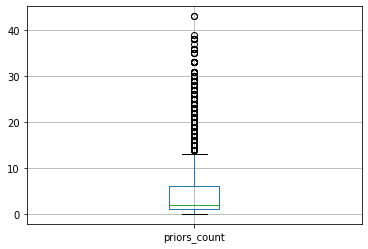

In [46]:
# now, we need to bin the `priors_count` variable to make it categorical
# with a Box and Whisker plot, we can assess how the data are distributed
plot, plt_stats = df_compas_violent_filt.boxplot("priors_count", grid=True, return_type="both")
plot

Clearly, majority of cases have fewer than 10 prior offenses, but there are a lot of outliers!

In [47]:
outliers = [flier.get_ydata() for flier in plt_stats["fliers"]]
boxes = [box.get_ydata() for box in plt_stats["boxes"]]
medians = [median.get_ydata() for median in plt_stats["medians"]]
whiskers = [whiskers.get_ydata() for whiskers in plt_stats["whiskers"]]

(array([445., 303., 184., 109.,  70.,  44.,  11.,   9.,   7.,   2.]),
 array([14. , 16.9, 19.8, 22.7, 25.6, 28.5, 31.4, 34.3, 37.2, 40.1, 43. ]),
 <a list of 10 Patch objects>)

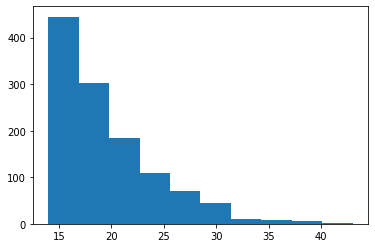

In [48]:
# plot s histogram of our outliers to see where most of them fall
np.set_printoptions(threshold=np.inf)
matplotlib.pyplot.hist(outliers)

OK, so most of our outliers are in the mid teens - low twenties

In [49]:
whiskers # whiskers are from values 0-1, 6-13, meaning outliers start at 14 prior counts

[array([1., 0.]), array([ 6., 13.])]

In [50]:
# see exactly what the quantile values are in our Box plot to understand exactly what the cutoffs are
df_compas_violent_filt["priors_count"].quantile([0.01, 0.25, 0.5, 0.75, 0.99])

0.01     0.0
0.25     1.0
0.50     2.0
0.75     6.0
0.99    24.0
Name: priors_count, dtype: float64

It looks like `priors_count` should be grouped by 0, 1, 2-5, 6-12, 13+. Let's double check the distribution of prior counts by looking at the occurences of each value

In [51]:
# see how many occurences of each prior count there are 
df_compas_violent_filt["priors_count"].value_counts()

0     4355
1     3212
2     2079
3     1446
4     1014
5      897
6      654
7      607
8      509
9      456
10     329
11     275
13     246
12     233
14     173
15     139
16     133
17     105
18     103
19      95
20      71
21      59
22      54
23      51
28      30
24      30
25      28
26      24
29      20
27      16
31      14
33      11
30      10
38       6
36       5
35       3
43       2
39       1
37       1
Name: priors_count, dtype: int64

By adding up the number of values we'd lump into each category(e.g. 0, 1, 2-5, 6-12, 13+), we see that they're fairly well distributed. Great! Now we need to create a new `priors_count_cat` column in our dataframe where we regroup the `priors_count` variable into bins "0", "1", "2-5", "6-12", and "13+"

In [52]:
def create_priors_cat(row):
    if row == 0 :
        return "0"
    if row == 1 :
        return "1"
    if row >= 2 and row < 6:
        return "2-5"
    if row >= 6 and row < 13:
        return "6 - 12"
    if row >= 13:
        return "13+"

In [53]:
priors_cat = df_compas_violent_filt.apply(lambda row: create_priors_cat(row["priors_count"]), axis=1)

In [54]:
# check out the distribution of prior counts across our new categories! do they seem balanced to you?
priors_cat.value_counts()

2-5       5436
0         4355
1         3212
6 - 12    3063
13+       1430
dtype: int64

In [55]:
# now that we're happy with the binning, let's add this series as a new column in our dataframe!
df_compas_violent_filt["priors_count_cat"] = priors_cat
df_compas_violent_filt.head()

,id,name,first,last,sex,dob,age,age_cat,race,decile_score,...,vr_charge_degree,vr_offense_date,vr_charge_desc,type_of_assessment,score_text,screening_date,v_type_of_assessment,v_decile_score,v_score_text,priors_count_cat
0,1.0,miguel hernandez,miguel,hernandez,Male,18/04/1947,69,Greater than 45,Other,1,...,NaN,NaN,NaN,Risk of Recidivism,Low,14/08/2013,Risk of Violence,1,Low,0
1,2.0,miguel hernandez,miguel,hernandez,Male,18/04/1947,69,Greater than 45,Other,1,...,NaN,NaN,NaN,Risk of Recidivism,Low,14/08/2013,Risk of Violence,1,Low,0
3,4.0,kevon dixon,kevon,dixon,Male,22/01/1982,34,25 - 45,African-American,3,...,(F3),05/07/2013,Felony Battery (Dom Strang),Risk of Recidivism,Low,27/01/2013,Risk of Violence,1,Low,0
4,5.0,ed philo,ed,philo,Male,14/05/1991,24,Less than 25,African-American,4,...,NaN,NaN,NaN,Risk of Recidivism,Low,14/04/2013,Risk of Violence,3,Low,2-5
5,6.0,ed philo,ed,philo,Male,14/05/1991,24,Less than 25,African-American,4,...,NaN,NaN,NaN,Risk of Recidivism,Low,14/04/2013,Risk of Violence,3,Low,2-5


Great, now that our data are cleaned of unclear recidivist cases, we have removed unnecessary columns, and we've redefined our `prior counts` data so we can include it as a categorical feature, now we can move on.

### Let's select the features together?

In [56]:
target = 'score_text'
protected = 'race'

params = {col : False for col in set(df_compas_violent_filt.columns)- set([target, protected])}

In [57]:
df_selected = None


def clean_data(**params):
    global df_selected
    df_selected = df_compas_violent_filt.copy(deep=True) # Refresh raw data at every interaction
    
    dropped_cols = [k for k in params if not params[k]] # Features with unmarked check boxes
    
    df_selected.drop(dropped_cols, inplace=True, axis=1) # Switching off features by dropping them
    df_selected.dropna(inplace=True)
    
    return df_selected


inter1=interactive(clean_data, **params)
display(inter1)

interactive(children=(Checkbox(value=False, description='name'), Checkbox(value=False, description='vr_charge_…

In [58]:
df_selected.head()

,race,score_text
0,Other,Low
1,Other,Low
3,African-American,Low
4,African-American,Low
5,African-American,Low


In [59]:
# Should feature selection be done by the instructor using the interface?
selected_features = list(set(df_selected.columns) - set([target]))
cols_of_interest = selected_features + [target]
df_selected = pd.get_dummies(df_selected, columns=selected_features)

In [60]:
encoding = {'Low' : 0, 'Medium' : 1, 'High' : 2} # necessary to code variables for sklearn
df_selected[target] = df_selected[target].apply(lambda x: encoding[x])

In [61]:
df_selected.head()

,score_text,race_African-American,race_Asian,race_Caucasian,race_Hispanic,race_Native American,race_Other
0,0,0,0,0,0,0,1
1,0,0,0,0,0,0,1
3,0,1,0,0,0,0,0
4,0,1,0,0,0,0,0
5,0,1,0,0,0,0,0


In [62]:
df_selected.columns

Index(['score_text', 'race_African-American', 'race_Asian', 'race_Caucasian',
       'race_Hispanic', 'race_Native American', 'race_Other'],
      dtype='object')

In [83]:
def calculate_accuracy(X_test, y_test):
    """Takes a test dataset and evaluates the accuracy with the model created in prior step."""
    global estimator
    accuracy = None
    score = None
    
    ### For DecisionTree with categorical classifications
    #predictions = estimator.predict(X_test)
    #accuracy = accuracy_score(y_test, predictions) 
    
    ### For DecisionTreeRegressor with continuous output
    score = estimator.score(X_test, y_test)
    
    return accuracy or score

### Let's see how a Decision Tree looks like?

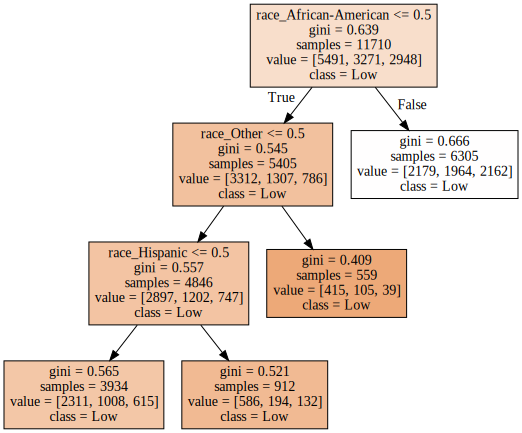

In [96]:
# Vanilla ML
global estimator
X = df_selected[set(df_selected.columns) - set([target])]
Y = df_selected[target]
X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=0.33, random_state=42)
estimator = DecisionTreeClassifier(random_state=0, criterion='gini', splitter='best', max_depth=3)
estimator.fit(X_train, y_train)

# Render Decision Tree
labels = X.columns
graph = Source(export_graphviz(estimator, out_file=None, feature_names=labels, class_names=['Low', 'Medium', 'High'], filled=True))
display(SVG(graph.pipe(format='svg')))

In [97]:
results = calculate_accuracy(X_test, y_test)
results

0.45553822152886114

In [86]:
# save the decision tree to your local files
graph.render("dt_w_priors_cat")

'dt_w_priors_cat.pdf'

### What happens if we manually decrease the risk of African-Americans?

In [99]:
protected_value = 'race_African-American'


# If a given row x (a training example) has 'racepctblack' greater than the median value, then
# multiply the outcome 'ViolentCrimesPerPop' by the user-defined ratio; otherwise, multiply by
# the inverse of the user-defined ratio.
# Interpretation: the greater the ratio, the worst is the bias against communities with above
# average Black populations; the smaller the ratio, the more favorable is the bias; setting to
# 1.0 keeps the data in its original form.

def apply_bias(x):
    global protected_value
    if (x[protected_value] and x[target] != 0):
        return x[target] - 1
    return x[target]


def plot_tree(repair_data):
    global X, Y, X_train, X_test, y_train, y_test, estimator
    df_biased = df_selected.copy(deep=True)
    if repair_data:
        df_biased[target] = df_biased.apply(apply_bias, axis=1)
    
    # Vanilla ML
    X = df_biased[set(df_biased.columns) - set([target])]
    Y = df_biased[target]
    X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=0.33, random_state=42)
    estimator = DecisionTreeClassifier(random_state=0, criterion='gini', splitter='best', max_depth=3)
    estimator.fit(X_train, y_train)
    
    # Render Decision Tree
    labels = X.columns
    graph = Source(export_graphviz(estimator, out_file=None, feature_names=labels, class_names=['Low', 'Medium', 'High'], filled=True))
    display(SVG(graph.pipe(format='svg')))
    return estimator


inter2=interactive(plot_tree, repair_data=True)
display(inter2)

interactive(children=(Checkbox(value=True, description='repair_data'), Output()), _dom_classes=('widget-intera…

In [101]:
results = calculate_accuracy(X_test, y_test)
results

0.6209048361934477

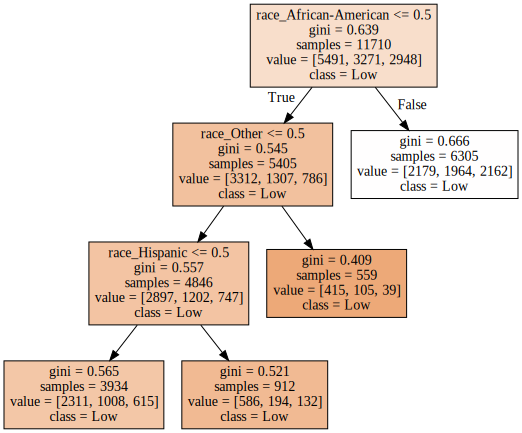

In [102]:
# Vanilla ML
global X, Y, estimator
X = df_selected[set(df_selected.columns) - set([target])]
Y = df_selected[target]
X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=0.33, random_state=42)
estimator = DecisionTreeClassifier(random_state=0, criterion='gini', splitter='best', max_depth=3)
estimator.fit(X_train, y_train)

# Render Decision Tree
labels = X.columns
graph = Source(export_graphviz(estimator, out_file=None, feature_names=labels, class_names=['Low', 'Medium', 'High'], filled=True))
display(SVG(graph.pipe(format='svg')))

In [103]:
results = calculate_accuracy(X_test, y_test)
results

0.45553822152886114

### What happens if racial profiling skews the data even further?

In [105]:
protected_value = 'race_African-American'


# If a given row x (a training example) has 'racepctblack' greater than the median value, then
# multiply the outcome 'ViolentCrimesPerPop' by the user-defined ratio; otherwise, multiply by
# the inverse of the user-defined ratio.
# Interpretation: the greater the ratio, the worst is the bias against communities with above
# average Black populations; the smaller the ratio, the more favorable is the bias; setting to
# 1.0 keeps the data in its original form.

def apply_bias(x):
    global protected_value
    if (x[protected_value] and x[target] != 2):
        return x[target] + 1
    return x[target]


def plot_tree(racial_profiling=False):
    global estimator
    df_biased = df_selected.copy(deep=True)
    df_biased[target] = df_biased.apply(apply_bias, axis=1)
    
    # Vanilla ML
    X = df_biased[set(df_biased.columns) - set([target])]
    Y = df_biased[target]
    X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=0.33, random_state=42)
    estimator = DecisionTreeClassifier(random_state=0, criterion='gini', splitter='best', max_depth=3)
    estimator.fit(X_train, y_train)
    
    # Render Decision Tree
    labels = X.columns
    graph = Source(export_graphviz(estimator, out_file=None, feature_names=labels, class_names=['Low', 'Medium', 'High'], filled=True))
    display(SVG(graph.pipe(format='svg')))
    return estimator


inter2=interactive(plot_tree, racial_profiling=False)
display(inter2)

interactive(children=(Checkbox(value=False, description='racial_profiling'), Output()), _dom_classes=('widget-…

In [106]:
results = calculate_accuracy(X_test, y_test)
results

0.47269890795631825